In [1]:

import nengo
import numpy as np
import time

import tkinter as tk
import os
from PIL import Image
from sklearn.model_selection import train_test_split

from nengo_extras.data import one_hot_from_labels
from nengo_extras.matplotlib import tile
from nengo_extras.vision import Gabor, Mask

import threading
import queue
import pickle
import nengo_dl
import tensorflow as tf

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import random

%matplotlib inline
style.use('fivethirtyeight')
sns.set(style='whitegrid', color_codes=True)
from sklearn.model_selection import train_test_split


import os
from random import shuffle
from zipfile import ZipFile
from PIL import Image

C:\Users\User\AppData\Roaming\Python\Python310\site-packages\nengo_dl\version.py:58: UserWarning: This version of NengoDL has not been tested with your Nengo version (4.0.0). The latest fully supported version is 3.2.0.
  warnings.warn(warnstr)


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import random

%matplotlib inline
style.use('fivethirtyeight')
sns.set(style='whitegrid', color_codes=True)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, SGD, Adagrad, Adadelta, RMSprop
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, CSVLogger, ReduceLROnPlateau

import tensorflow as tf
import random as rn

import os
from random import shuffle
from zipfile import ZipFile
from PIL import Image

In [3]:
input_width = 160
input_height = 60
n_hid = 1000

lookup = dict()
reverselookup = dict()
count = 0
for j in os.listdir('./input/leapgestrecog/leapGestRecog/00/'):
    if not j.startswith('.'): # If running this code locally, this is to 
                              # ensure you aren't reading in hidden folders
        lookup[j] = count
        reverselookup[count] = j
        count = count + 1
lookup


x_data = []
y_data = []
datacount = 0 # We'll use this to tally how many images are in our dataset
for i in range(0, 10): # Loop over the ten top-level folders
    for j in os.listdir('./input/leapgestrecog/leapGestRecog/0' + str(i) + '/'):
        if not j.startswith('.'): # Again avoid hidden folders
            count = 0 # To tally images of a given gesture
            for k in os.listdir('./input/leapgestrecog/leapGestRecog/0' + 
                                str(i) + '/' + j + '/'):
                                # Loop over the images
                img = Image.open('./input/leapgestrecog/leapGestRecog/0' + 
                                 str(i) + '/' + j + '/' + k).convert('L')
                                # Read in and convert to greyscale
                img = img.resize((input_width, input_height))
                arr = np.array(img)
                x_data.append(arr) 
                count = count + 1
            y_values = np.full((count, 1), lookup[j]) 
            y_data.append(y_values)
            datacount = datacount + count
x_data = np.array(x_data, dtype = 'float32')
x_data = x_data / 255 * 2 - 1
print(x_data.shape)
#x_data = x_data.reshape(datacount, -1)

y_data = np.array(y_data)
y_data = y_data.reshape(datacount)


(20000, 60, 160)


In [4]:
x_data = x_data.reshape((x_data.shape[0], 1, -1))
y_data = y_data.reshape((y_data.shape[0], 1, -1))


In [4]:
print(x_data.shape)

(20000, 1, 784)


In [5]:
x_train,x_further,y_train,y_further = train_test_split(x_data,y_data,test_size = 0.2, random_state=42)
x_validate,x_test,y_validate,y_test = train_test_split(x_further,y_further,test_size = 0.5, random_state=42)

In [11]:
print(x_validate.shape)


(2000, 1, 784)


In [6]:
# input
inp = tf.keras.Input(shape=(input_height, input_width, 1))

# convolutional layers
conv0 = tf.keras.layers.Conv2D(
    filters=32,
    kernel_size=3,
    activation=tf.nn.relu,
)(inp)

conv1 = tf.keras.layers.Conv2D(
    filters=64,
    kernel_size=3,
    strides=2,
    activation=tf.nn.relu,
)(conv0)

# fully connected layer
flatten = tf.keras.layers.Flatten()(conv1)
dense = tf.keras.layers.Dense(units=10)(flatten)

model = tf.keras.Model(inputs=inp, outputs=dense)

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"])

In [ ]:
History = model.fit(x_train, y_train, epochs=7, batch_size=120, verbose=1, validation_data=(x_validate, y_validate))

In [7]:
converter = nengo_dl.Converter(model)

In [8]:
do_training = True
if do_training:
    with nengo_dl.Simulator(converter.net, minibatch_size=200) as sim:
        # run training
        sim.compile(
            optimizer=tf.optimizers.Adam(0.001),
            loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=[tf.metrics.sparse_categorical_accuracy],
        )
        sim.fit(
            {converter.inputs[inp]: x_train},
            {converter.outputs[dense]: y_train},
            validation_data=(
                {converter.inputs[inp]: x_test},
                {converter.outputs[dense]: y_test},
            ),
            epochs=3,
        )

        # save the parameters to file
        sim.save_params("./keras_to_snn_big_params")


|                     Building network (0%)                    | ETA:  --:--:--
|                     Building network (0%)                    | ETA:  --:--:--


C:\Users\User\AppData\Roaming\Python\Python310\site-packages\nengo_dl\simulator.py:456: UserWarning: No GPU support detected. See https://www.nengo.ai/nengo-dl/installation.html#installing-tensorflow for instructions on setting up TensorFlow with GPU support.
  warnings.warn(


|                     Building network (0%)                    | ETA:  --:--:--
|                     Building network (0%)                    | ETA:  --:--:--
|                     Building network (0%)                    | ETA:  --:--:--
|                     Building network (0%)                    | ETA:  --:--:--
|                     Building network (0%)                    | ETA:  --:--:--
|                     Building network (0%)                    | ETA:  --:--:--
|                     Building network (0%)                    | ETA:  --:--:--
|                     Building network (0%)                    | ETA:  --:--:--
|                     Building network (0%)                    | ETA:  --:--:--
|                     Building network (0%)                    | ETA:  --:--:--
|                     Building network (0%)                    | ETA:  --:--:--
|###                   Building network (5%)                     | ETA: 0:00:24
|###                   Building network 

In [14]:
def run_network(
    activation,
    params_file="keras_to_snn_big_params",
    n_steps=30,
    scale_firing_rates=1,
    synapse=None,
    n_test=400,
):
    # convert the keras model to a nengo network
    nengo_converter = nengo_dl.Converter(
        model,
        swap_activations={tf.nn.relu: activation},
        scale_firing_rates=scale_firing_rates,
        synapse=synapse,
    )

    # get input/output objects
    nengo_input = nengo_converter.inputs[inp]
    nengo_output = nengo_converter.outputs[dense]

    # add a probe to the first convolutional layer to record activity.
    # we'll only record from a subset of neurons, to save memory.
    sample_neurons = np.linspace(
        0,
        np.prod(conv0.shape[1:]),
        1000,
        endpoint=False,
        dtype=np.int32,
    )
    with nengo_converter.net:
        conv0_probe = nengo.Probe(nengo_converter.layers[conv0][sample_neurons])

    # repeat inputs for some number of timesteps
    tiled_test_images = np.tile(x_test[:n_test], (1, n_steps, 1))

    # set some options to speed up simulation
    with nengo_converter.net:
        nengo_dl.configure_settings(stateful=False)

    # build network, load in trained weights, run inference on test images
    with nengo_dl.Simulator(
        nengo_converter.net, minibatch_size=10, progress_bar=False
    ) as nengo_sim:
        nengo_sim.load_params(params_file)
        data = nengo_sim.predict({nengo_input: tiled_test_images})

    # compute accuracy on test data, using output of network on
    # last timestep
    predictions = np.argmax(data[nengo_output][:, -1], axis=-1)
    accuracy = (predictions == y_test[:n_test, 0, 0]).mean()
    print(f"Test accuracy: {100 * accuracy:.2f}%")

    # plot the results
    for ii in range(3):
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 3, 1)
        plt.title("Input image")
        plt.imshow(x_test[ii, 0].reshape((60, 160)), cmap="gray")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        scaled_data = data[conv0_probe][ii] * scale_firing_rates
        if isinstance(activation, nengo.SpikingRectifiedLinear):
            scaled_data *= 0.001
            rates = np.sum(scaled_data, axis=0) / (n_steps * nengo_sim.dt)
            plt.ylabel("Number of spikes")
        else:
            rates = scaled_data
            plt.ylabel("Firing rates (Hz)")
        plt.xlabel("Timestep")
        plt.title(
            f"Neural activities (conv0 mean={rates.mean():.1f} Hz, "
            f"max={rates.max():.1f} Hz)"
        )
        plt.plot(scaled_data)

        plt.subplot(1, 3, 3)
        plt.title("Output predictions")
        plt.plot(tf.nn.softmax(data[nengo_output][ii]))
        plt.legend([str(j) for j in range(10)], loc="upper left")
        plt.xlabel("Timestep")
        plt.ylabel("Probability")

        plt.tight_layout()

40/40 [==============================] - 161s 4s/step
Test accuracy: 100.00%


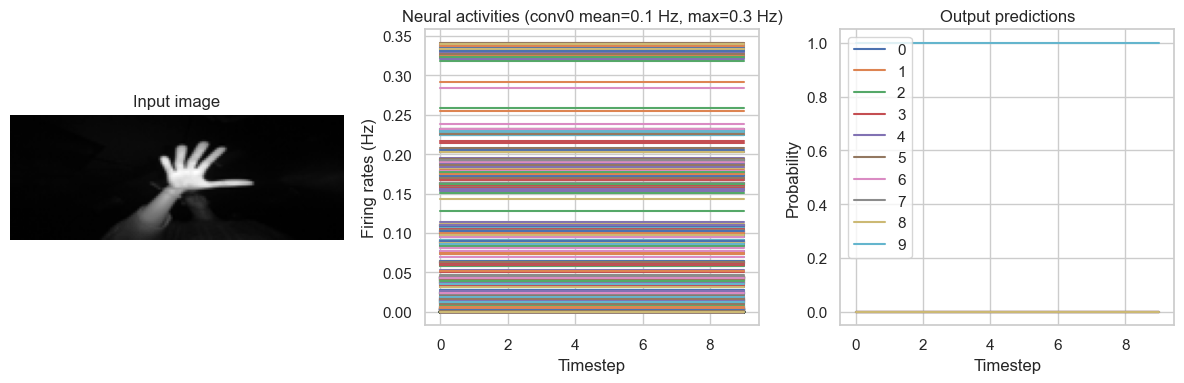

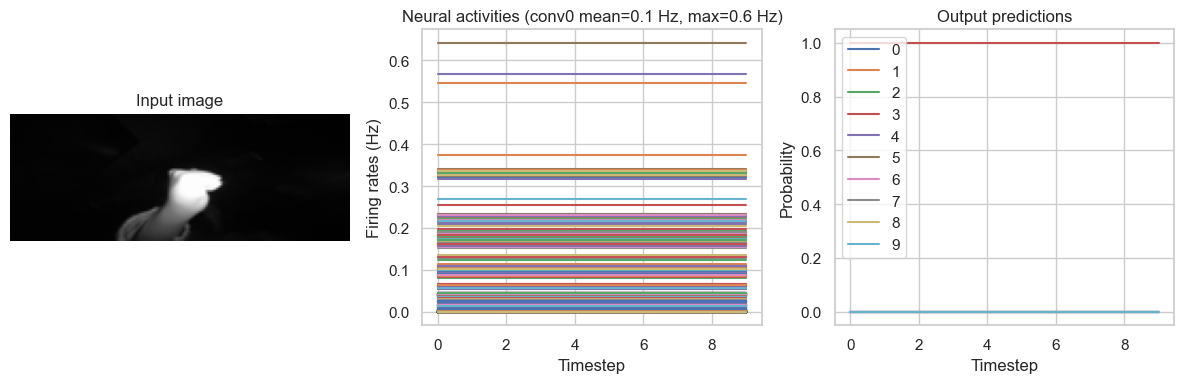

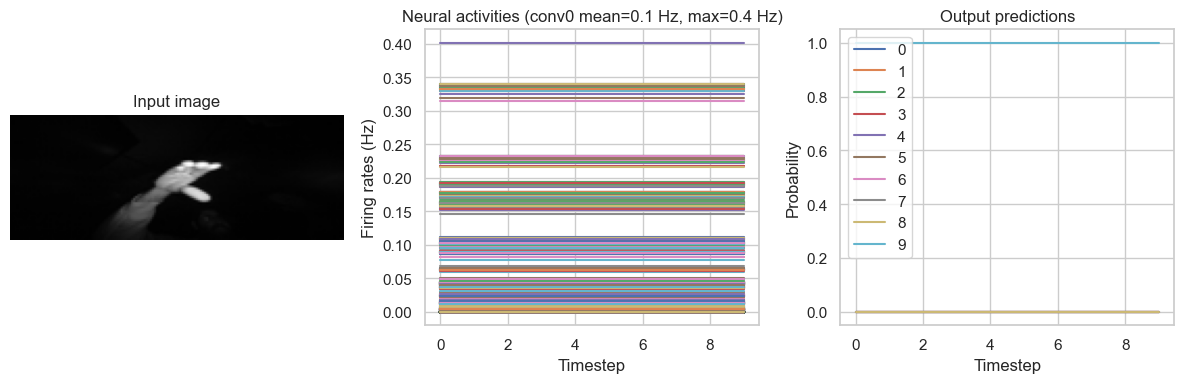

In [15]:
run_network(activation=nengo.RectifiedLinear(), n_steps=10)

40/40 [==============================] - 495s 12s/step
Test accuracy: 9.50%


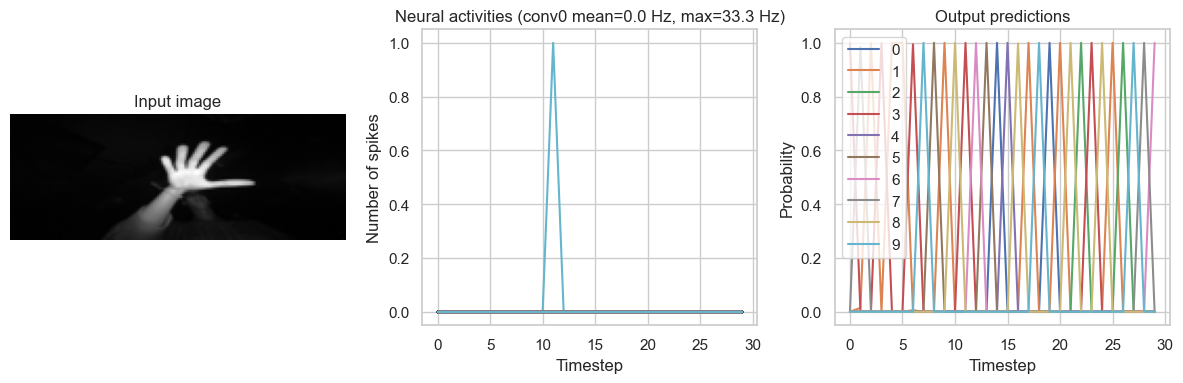

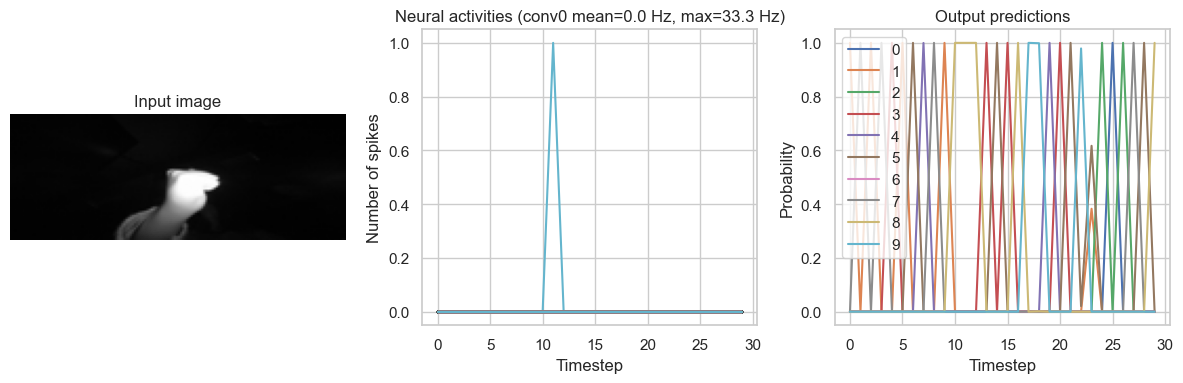

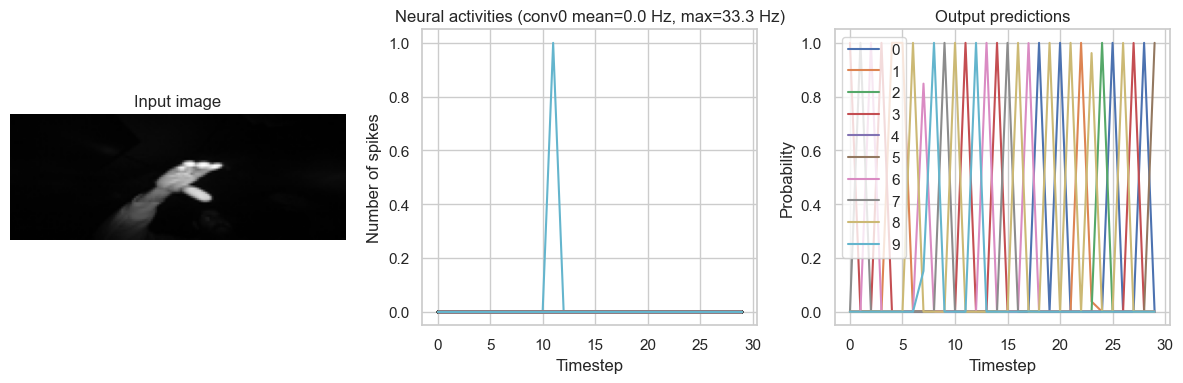

In [16]:
run_network(activation=nengo.SpikingRectifiedLinear())

Synapse=0.001
40/40 [==============================] - 685s 17s/step
Test accuracy: 11.25%


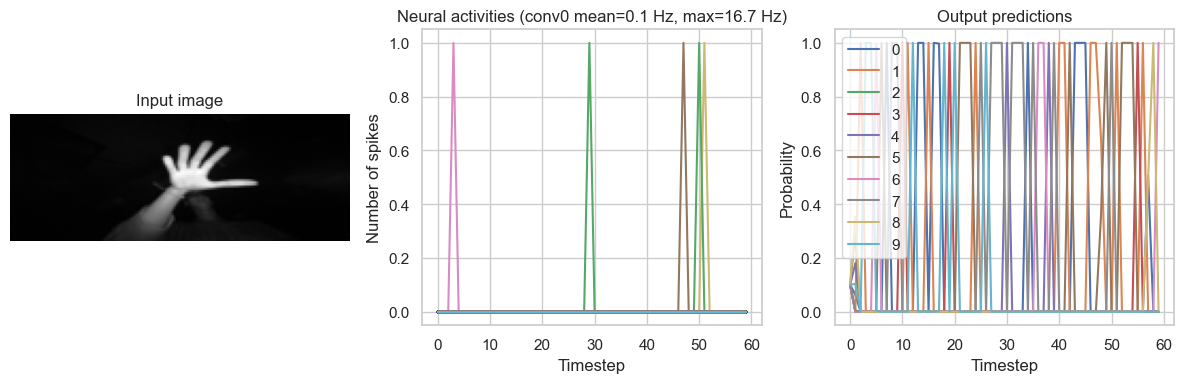

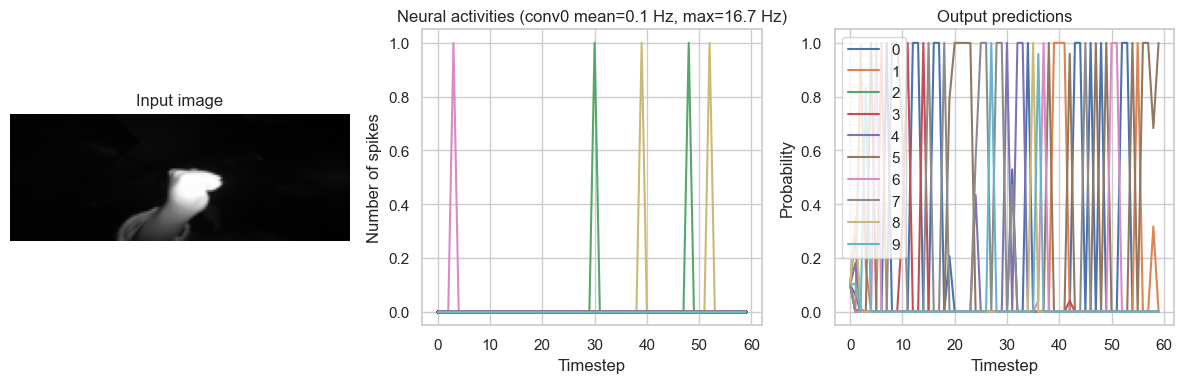

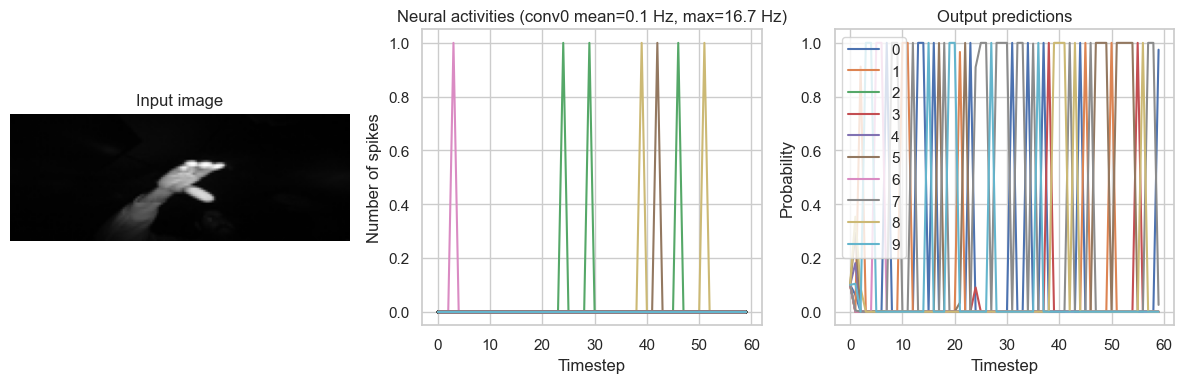

Synapse=0.005
40/40 [==============================] - 684s 17s/step
Test accuracy: 20.00%


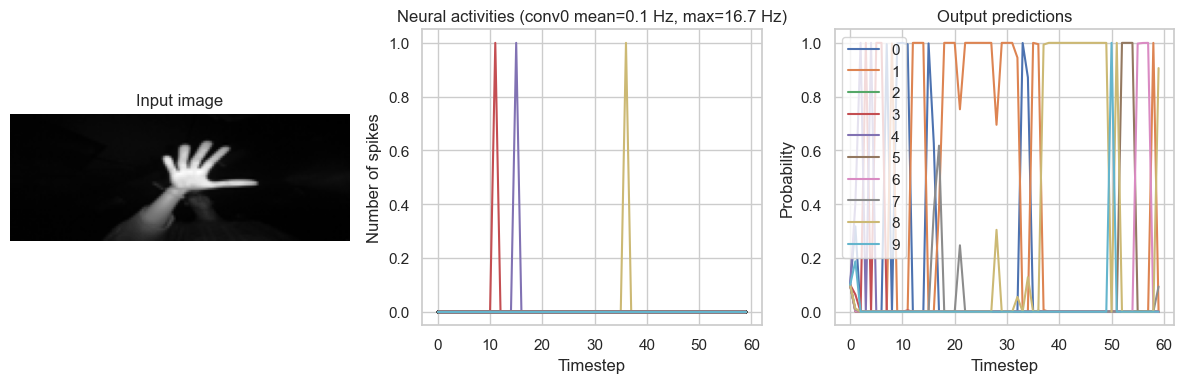

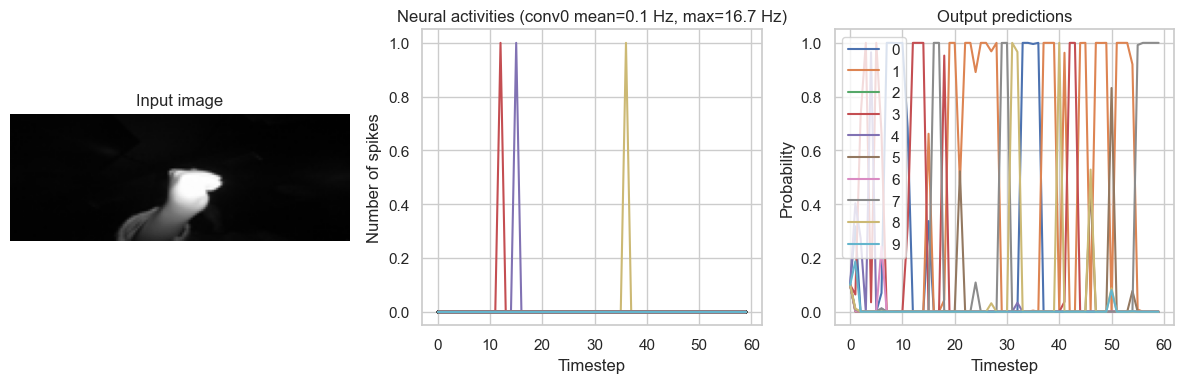

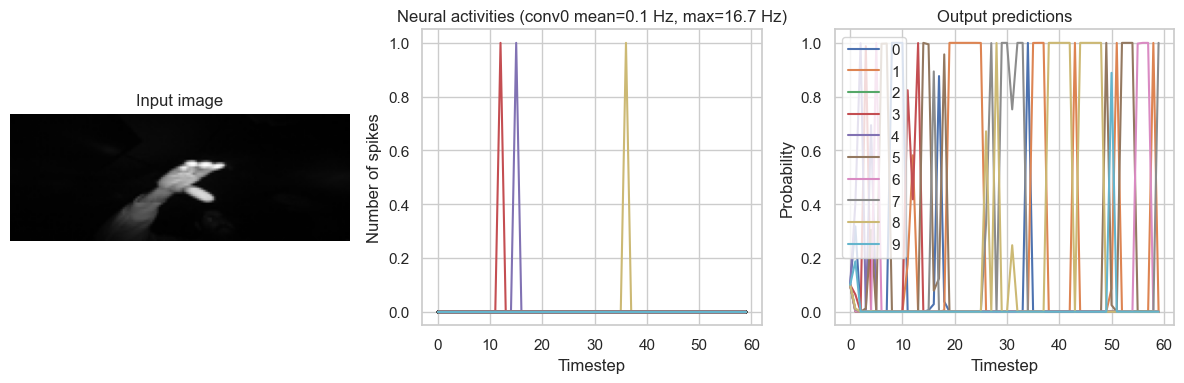

Synapse=0.010
40/40 [==============================] - 672s 17s/step
Test accuracy: 23.50%


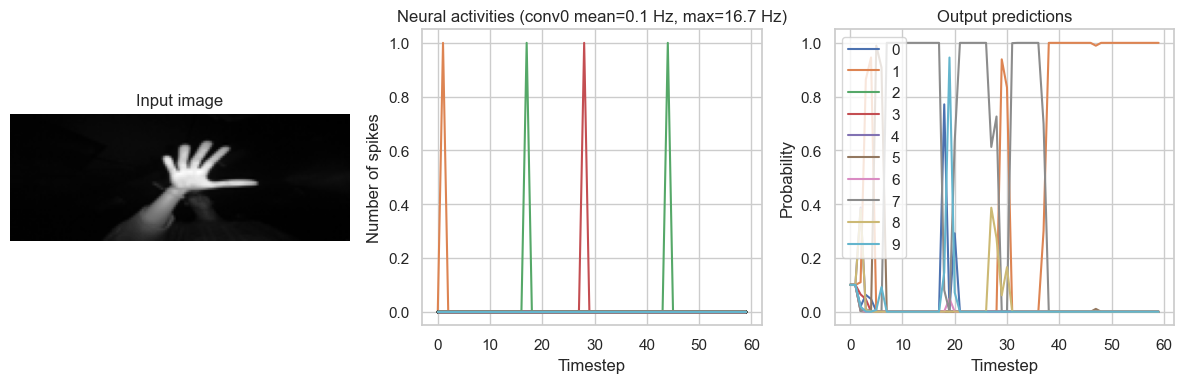

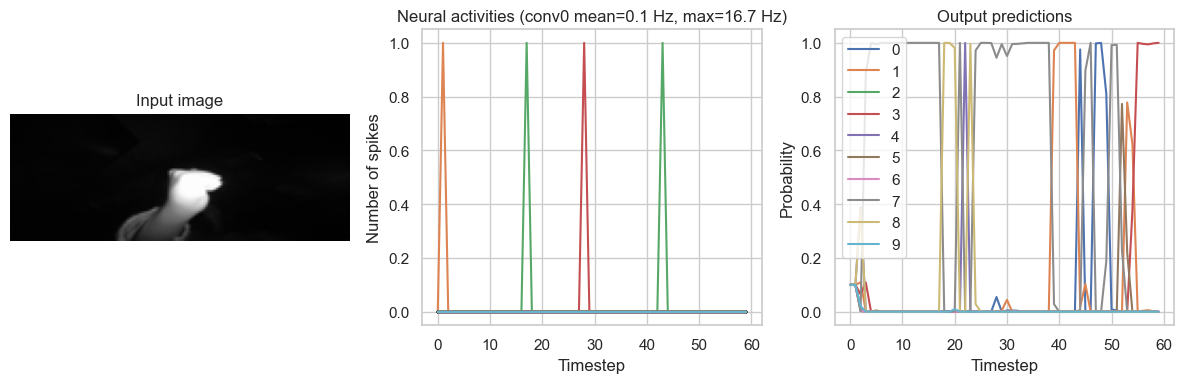

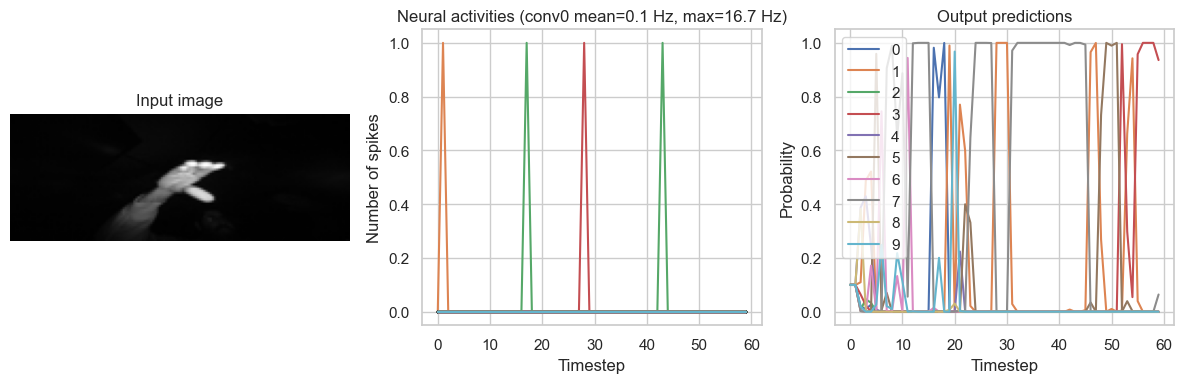

In [17]:
for s in [0.001, 0.005, 0.01]:
    print(f"Synapse={s:.3f}")
    run_network(
        activation=nengo.SpikingRectifiedLinear(),
        n_steps=60,
        synapse=s,
    )
    plt.show()

Scale=100
40/40 [==============================] - 484s 12s/step
Test accuracy: 90.00%


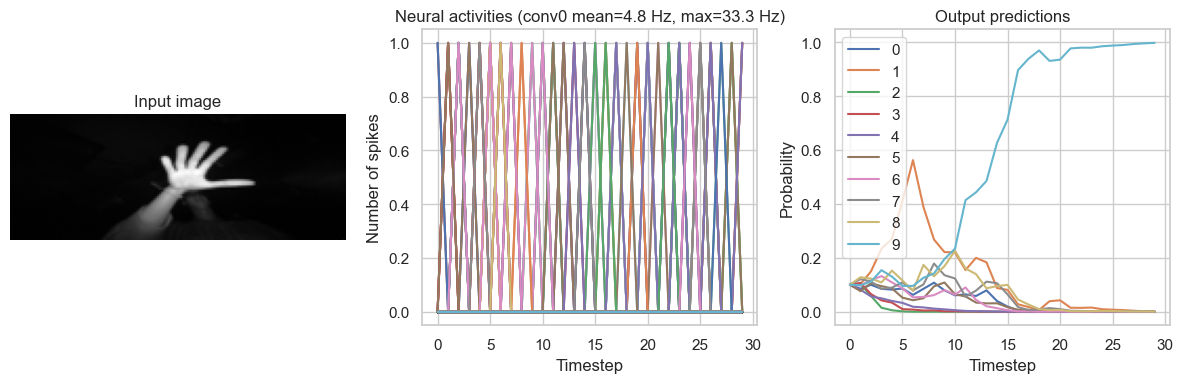

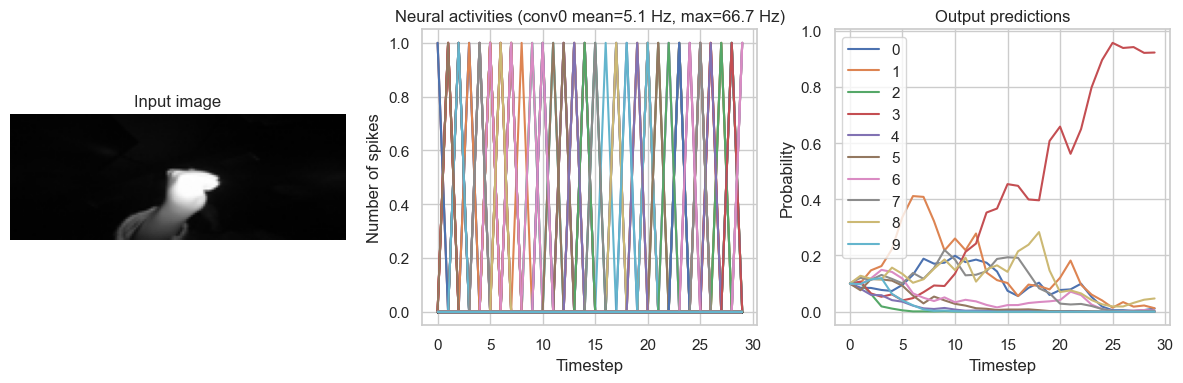

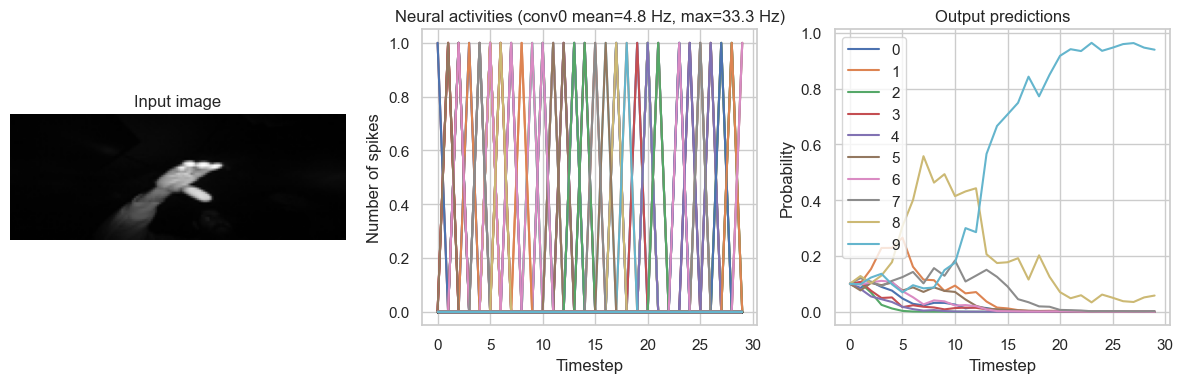

In [22]:
for scale in [ 100]:
    print(f"Scale={scale}")
    run_network(
        activation=nengo.SpikingRectifiedLinear(),
        scale_firing_rates=scale,
        synapse=0.01,
    )
    plt.show()